## New sample selection methods are yielding opposite results as those used in January. This notebook should find the cause. 

## The plan: Apply old and new cuts to old and new versions of the data

## Old cuts:

Disks: 

$p_{features}>0.5, N_{edgeon} \ge 10, p_{edgeon,no} > .35$

Surface brightness:

MU_HI < 21.5

## New cuts:

Disks:

$p_{features}>0.23, N_{edgeon} \ge 10, p_{edgeon,no} > .45, p_{clumpy,no}>.3$

Magnitude:

Absolute mag MR < -20.5

## Old data:

Debiased catalog from December. 

## New data: 

Debiased catalog from March (most recent version as of 5-2016). The only data that would change between the two are $p_{features,best}$ and redshift, since the debiasing had been tweaked and rerun since then, as well as the catalog was updated with more accurate redshifts. 

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os
import scipy.stats.distributions as dist

from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [2]:
#load the data - #70,198 galaxies matched between COSMOS and UV
data=Table.read('../data/cosmos_uv_matched_catalog.fits')
old_data = Table.read('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog.fits')

#load cut values from red_disk_sample: 
cuts=Table.read('../data/red_disk_cuts.fits')

#GZH vote fractions
p_features = 't01_smooth_or_features_a02_features_or_disk_best_fraction'
p_clumpy_no = 't12_clumpy_a02_no_weighted_fraction'
p_edgeon_no = 't02_edgeon_a02_no_weighted_fraction'
N_edgeon = 't02_edgeon_total_weight'


z_lim = (data['Z_BEST']>=.2) & (data['Z_BEST']<=1)
old_z_lim = (old_data['Z_BEST_COMBINED']>=.2) & (old_data['Z_BEST_COMBINED']<=1)

#define disk sample
featured = (data[p_features]>cuts['p_features_cut']) 
not_clumpy =  (data[p_clumpy_no]>cuts['p_clumpy_no_cut']) 
faceon =  (data[p_edgeon_no]>cuts['p_edgeon_no_cut']) 
N_cut = (data[N_edgeon]>=cuts['N_edgeon_cut']) 
mag_lim = (data['MR']<cuts['mag_cut'])

#define red sequence
red_sequence = (data['classification']==0)
blue_cloud = (data['classification']==1)
old_red_sequence = (old_data['classification']==0)
old_blue_cloud = (old_data['classification']==1)



print 'Number of galaxies between .2<z<1: %s'%len(data[z_lim])
print 'Number of red galaxies: %s'%len(data[z_lim & red_sequence])
print 'Number of blue galaxies: %s'%len(data[z_lim & blue_cloud])

print ''

print 'Old data: Number of galaxies between .2<z<1: %s'%len(old_data[old_z_lim])
print 'Old data: Number of red galaxies: %s'%len(old_data[old_z_lim & old_red_sequence])
print 'Old data: Number of blue galaxies: %s'%len(old_data[old_z_lim & old_blue_cloud])


Number of galaxies between .2<z<1: 52685
Number of red galaxies: 10096
Number of blue galaxies: 42589

Old data: Number of galaxies between .2<z<1: 52707
Old data: Number of red galaxies: 10242
Old data: Number of blue galaxies: 42465


So far so good: Numbers of red and blue galaxies in this redshift range mostly match January. Small differences are from updates in redshift. Now other cuts. 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in greater


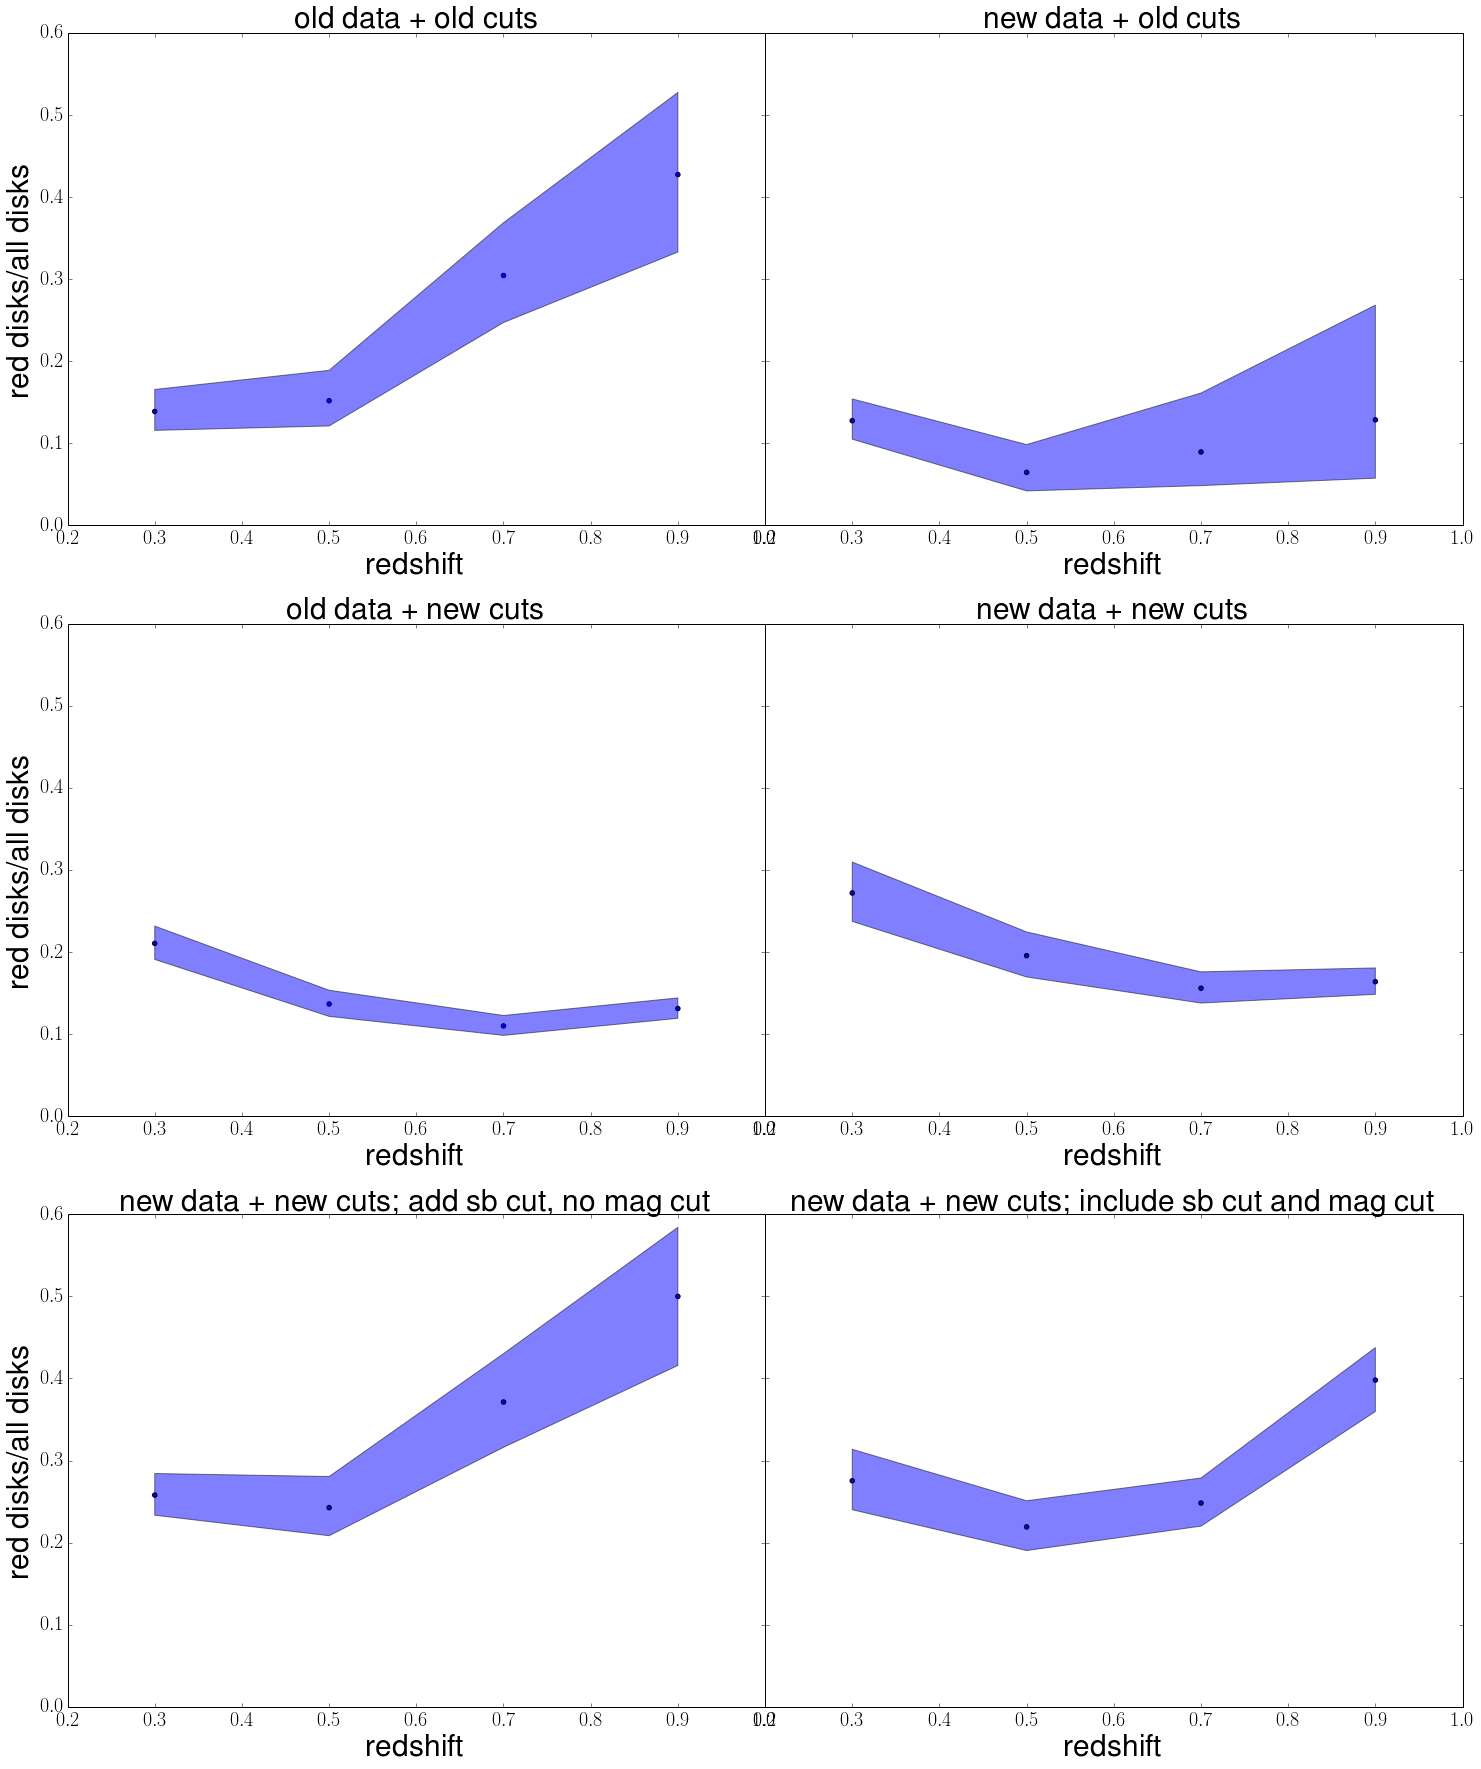

In [7]:
c=.95
fs=30
## old cuts on old data ###########################################33
f=plt.figure(figsize=(25,30))
gs = gridspec.GridSpec(3,2)
gs.update(wspace=0)
ax1 = plt.subplot(gs[0,0])
old_disks = (old_data[p_features]>.5) & (old_data[N_edgeon]>=10) & (old_data[p_edgeon_no]>.35)
old_sb_cut = (old_data['MU_HI']<21.5) 
z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (old_data['Z_BEST_COMBINED']>z_edges[i]) & (old_data['Z_BEST_COMBINED']<=z_edges[i+1])
    red_list.append(len(old_data[old_disks & old_sb_cut & z_range & old_red_sequence]))
    all_list.append(len(old_data[old_disks & old_sb_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)
    
z_list = [.3,.5,.7,.9]

plt.scatter(z_list,f_list)
ax1.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.xlim(.2,1)
plt.ylim(0,.6)
plt.xlabel('redshift',fontsize=fs)
plt.ylabel('red disks/all disks',fontsize=fs)
plt.title('old data + old cuts',fontsize=fs)

##old cuts on new data ##############################################################################

ax2 = plt.subplot(gs[0,1],sharey=ax1)
disks = (data[p_features]>.5) & (data[N_edgeon]>=10) & (data[p_edgeon_no]>.35)
sb_cut = (data['MU_HI']<21.5) 


z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
    red_list.append(len(data[disks & sb_cut & z_range & red_sequence]))
    all_list.append(len(data[disks & sb_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)

z_list = [.3,.5,.7,.9]

ax2.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.scatter(z_list,f_list)
plt.xlim(.2,1)
plt.xlabel('redshift',fontsize=fs)
plt.title('new data + old cuts',fontsize=fs)
plt.tick_params(labelleft='off')

## new cuts on old data ###########################################33
ax3 = plt.subplot(gs[1,0])
old_disks = (old_data[p_features]>cuts['p_features_cut']) & (old_data[N_edgeon]>=10) & (old_data[p_edgeon_no]>.45) & (old_data[p_clumpy_no]>cuts['p_clumpy_no_cut'])
old_mag_cut = (old_data['MR']<-20.5) 
z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (old_data['Z_BEST_COMBINED']>z_edges[i]) & (old_data['Z_BEST_COMBINED']<=z_edges[i+1])
    red_list.append(len(old_data[old_disks & old_mag_cut & z_range & old_red_sequence]))
    all_list.append(len(old_data[old_disks & old_mag_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)
    
z_list = [.3,.5,.7,.9]

plt.scatter(z_list,f_list)
ax3.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.xlim(.2,1)
plt.ylim(0,.6)
plt.xlabel('redshift',fontsize=fs)
plt.ylabel('red disks/all disks',fontsize=fs)
plt.title('old data + new cuts',fontsize=fs)

##new cuts on new data ##############################################################################

ax4 = plt.subplot(gs[1,1],sharey=ax3)
disks = (data[p_features]>cuts['p_features_cut']) & (data[N_edgeon]>=10) & (data[p_edgeon_no]>.45) & (data[p_clumpy_no]>cuts['p_clumpy_no_cut'])
mag_cut = (data['MR']<-21.5) 


z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
    red_list.append(len(data[disks  & mag_cut & z_range & red_sequence]))
    all_list.append(len(data[disks  & mag_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)

z_list = [.3,.5,.7,.9]

ax4.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.scatter(z_list,f_list)
plt.xlim(.2,1)
plt.ylim(0,.6)
plt.xlabel('redshift',fontsize=fs)
plt.title('new data + new cuts',fontsize=fs)
plt.tick_params(labelleft='off')

##new cuts on new data, sb cut instead of mag cut###############################################################


ax5 = plt.subplot(gs[2,0])
disks = (data[p_features]>cuts['p_features_cut']) & (data[N_edgeon]>=10) & (data[p_edgeon_no]>.45) & (data[p_clumpy_no]>cuts['p_clumpy_no_cut'])


z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
    red_list.append(len(data[disks & sb_cut  & z_range & red_sequence]))
    all_list.append(len(data[disks & sb_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)

z_list = [.3,.5,.7,.9]

ax5.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.scatter(z_list,f_list)
plt.xlim(.2,1)
plt.ylim(0,.6)
plt.xlabel('redshift',fontsize=fs)
plt.ylabel('red disks/all disks',fontsize=fs)
plt.title('new data + new cuts; add sb cut, no mag cut',fontsize=fs)


##new cuts on new data, sb cut and mag cut###############################################################

ax6 = plt.subplot(gs[2,1])
disks = (data[p_features]>cuts['p_features_cut']) & (data[N_edgeon]>=10) & (data[p_edgeon_no]>.45) & (data[p_clumpy_no]>cuts['p_clumpy_no_cut'])
mag_cut = (data['MR']<-21.5) 
sb_cut = (data['GZ_MU_HI']<19)

z_edges = [.2,.4,.6,.8,1]

red_list = []
all_list = []
for i in range(0,len(z_edges)-1):
    z_range = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1])
    red_list.append(len(data[disks & sb_cut & mag_cut & z_range & red_sequence]))
    all_list.append(len(data[disks & sb_cut & mag_cut & z_range]))

f_list = []
yerr_low=[]
yerr_hi=[]
for i in range(0,len(red_list)):
    N_red_disks = red_list[i]
    N_all_disks = all_list[i]
    p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
    frac = float(red_list[i])/all_list[i]
    yerr_low.append(p_l)
    yerr_hi.append(p_u)

    f_list.append(frac)

z_list = [.3,.5,.7,.9]

ax6.fill_between(z_list,yerr_low,yerr_hi,alpha=.5)
plt.scatter(z_list,f_list)
plt.xlim(.2,1)
plt.ylim(0,.6)
plt.xlabel('redshift',fontsize=fs)
plt.title('new data + new cuts; include sb cut and mag cut',fontsize=fs)
plt.tick_params(labelleft='off')






## Biggest difference comes from the inclusion of a surface brightness cut. 

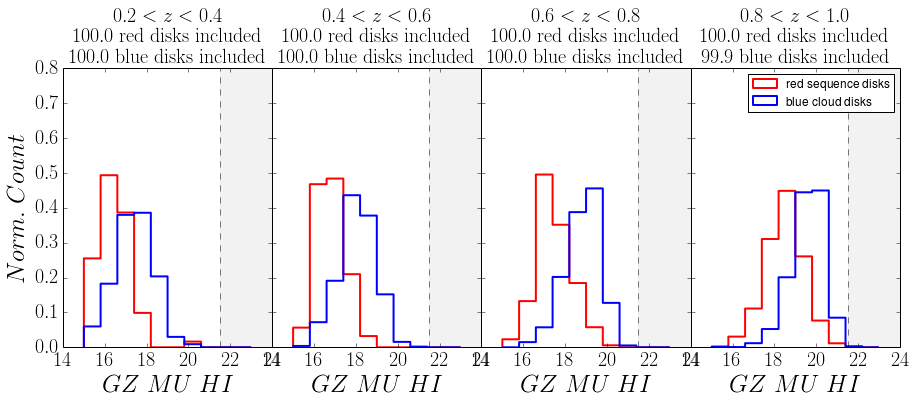

In [15]:
z_edges = [.2,.4,.6,.8,1.0]
sb_cut = (data['GZ_MU_HI']<21.5)
mag_cut = (data['MR']<-21.5) 
f=plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,4)
gs.update(wspace=0)
for i in range(0,len(z_edges)-1):
    ax = plt.subplot(gs[0,i])
    z_range = (data['Z_BEST']>z_edges[i]) & (data['Z_BEST']<=z_edges[i+1]) & mag_cut
    N_red_disks = len(data[red_sequence & disks & z_range])
    N_red_disks_kept = len(data[red_sequence & disks & z_range & sb_cut])
    N_blue_disks = len(data[blue_cloud & disks & z_range])
    N_blue_disks_kept = len(data[blue_cloud & disks & z_range & sb_cut])
    f_red = round(float(N_red_disks_kept)/N_red_disks*100.,1)
    f_blue = round(float(N_blue_disks_kept)/N_blue_disks*100.,1)

    plt.hist(data[red_sequence & disks & z_range]['GZ_MU_HI'],histtype='step',normed=True,color='r',range=(15,23),lw=2,label='red sequence disks')
    plt.hist(data[blue_cloud & disks & z_range]['GZ_MU_HI'],histtype='step',normed=True,color='b',range=(15,23),lw=2,label='blue cloud disks')
    plt.ylim(0,.8)
    plt.axvline(21.5,ls='dashed',lw=.5,c='k')
    if i!=0:
        plt.tick_params(labelleft='off')
    else:
        plt.ylabel('$Norm.~Count$',fontsize=25)
    plt.title('$%s<z<%s$\n $\mathrm{%s~red~disks~included}$\n $\mathrm{%s~blue~disks~included}$'%(z_edges[i],z_edges[i+1],f_red,f_blue),fontsize=20)
    plt.xlabel('$GZ~MU~HI$',fontsize=25)
    if i==3:
        plt.legend()
    plt.axvspan(21.5,28,alpha=.05,color='k')
    plt.xlim(14,24)

In [124]:
IGT24 = (old_data['MAGI']<24)
IGT225 = (old_data['MAGI']<22.5)

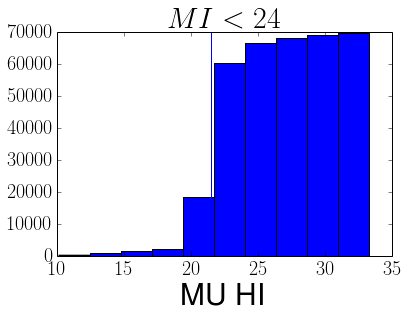

In [127]:
plt.hist(old_data[IGT24]['MU_HI'],cumulative=True)
plt.title('$MI<24$',fontsize=30)
plt.xlabel('MU HI',fontsize=30)
plt.axvline(21.5)

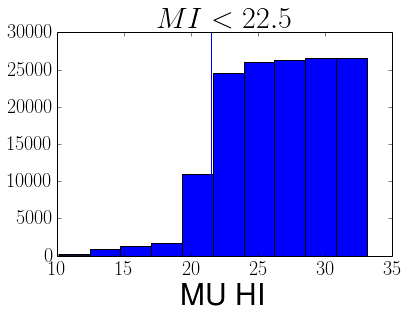

In [128]:
plt.hist(old_data[IGT225]['MU_HI'],cumulative=True)
plt.title('$MI<22.5$',fontsize=30)
plt.xlabel('MU HI',fontsize=30)
axvline(21.5)

In [131]:
r = 3.
b= 7 

In [132]:
r/(r+b)

0.3

In [134]:
.7*r/(.7*r+.32*b)

0.48387096774193544